# Rock, Paper, Scissors classifier with data augmentation

## Imports

In [1]:
# General imports
import numpy as np ; np.random.seed(1) # for reproducibility
import os
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import shutil
from datetime import datetime
%matplotlib inline

# TensorFlow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from keras.preprocessing import image

## TensorFlow information

In [2]:
# Indicate the version of Tensorflow and whether it uses the CPU or the GPU
print("TensorFlow version:", tf.__version__)

if len(tf.config.list_physical_devices('GPU')) > 0:
    print("The GPU will be used for calculations.")
    
else:
    print("The CPU will be used for calculations.")

TensorFlow version: 2.4.0
The CPU will be used for calculations.


## 1. Import data 

In [3]:
# Define OS
os_machine = 'macOS' # Windows | macOS | Linux
print('We are on', os_machine)

# Select if the data is downloaded for the first time (or refreshed)
refresh_data = False

if refresh_data:

    # Import dataset
    if os_machine == 'macOS' or os_machine == 'Linux':
        !wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip -O ./Data/rps.zip
        !wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip -O ./Data/rps-test-set.zip
    elif os_machine == 'Windows':
        !curl.exe --output "./Data/rps.zip" --url "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip"
        !curl.exe --output "./Data/rps-test-set.zip" --url "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip"

    # Unzip
    local_zip = './data/rps.zip'
    zip_ref = zipfile.ZipFile(local_zip, 'r')
    zip_ref.extractall('./data/')
    zip_ref.close()
    local_zip = './data/rps-test-set.zip'
    zip_ref = zipfile.ZipFile(local_zip, 'r')
    zip_ref.extractall('./data/')
    zip_ref.close()

We are on macOS
--2021-04-24 14:15:39--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.200.80, 216.58.215.144, 142.250.200.112, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.200.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 200682221 (191M) [application/zip]
Saving to: ‘./Data/rps.zip’

./Data/rps.zip      100%[===================>] 191,38M  15,0MB/s    in 17s     

2021-04-24 14:15:56 (11,5 MB/s) - ‘./Data/rps.zip’ saved [200682221/200682221]

--2021-04-24 14:15:57--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.200.80, 216.58.215.144, 142.250.200.112, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.200.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29516758 (28M) [applicatio

### Prepare folders

In [4]:
# Define directories
base_dir = './data'
train_dir = os.path.join(base_dir, 'rps')
validation_dir = os.path.join(base_dir, 'rps-test-set')

# Define train directories
train_rock_dir = os.path.join(train_dir, 'rock')
train_paper_dir = os.path.join(train_dir, 'paper')
train_scissors_dir = os.path.join(train_dir, 'scissors')

# Define validation directories
validation_rock_dir = os.path.join(validation_dir, 'rock')
validation_paper_dir = os.path.join(validation_dir, 'paper')
validation_scissors_dir = os.path.join(validation_dir, 'scissors')

## 2. Describe data

In [5]:
# Describe data size
print('Total training rock images:', len(os.listdir(train_rock_dir)))
print('Total training paper images:', len(os.listdir(train_paper_dir)))
print('Total validation scissors images:', len(os.listdir(train_scissors_dir)))

Total training rock images: 840
Total training paper images: 840
Total validation scissors images: 840


In [6]:
# Get names of pictures
rock_files = os.listdir(train_rock_dir)
paper_files = os.listdir(train_paper_dir)
scissors_files = os.listdir(train_scissors_dir)

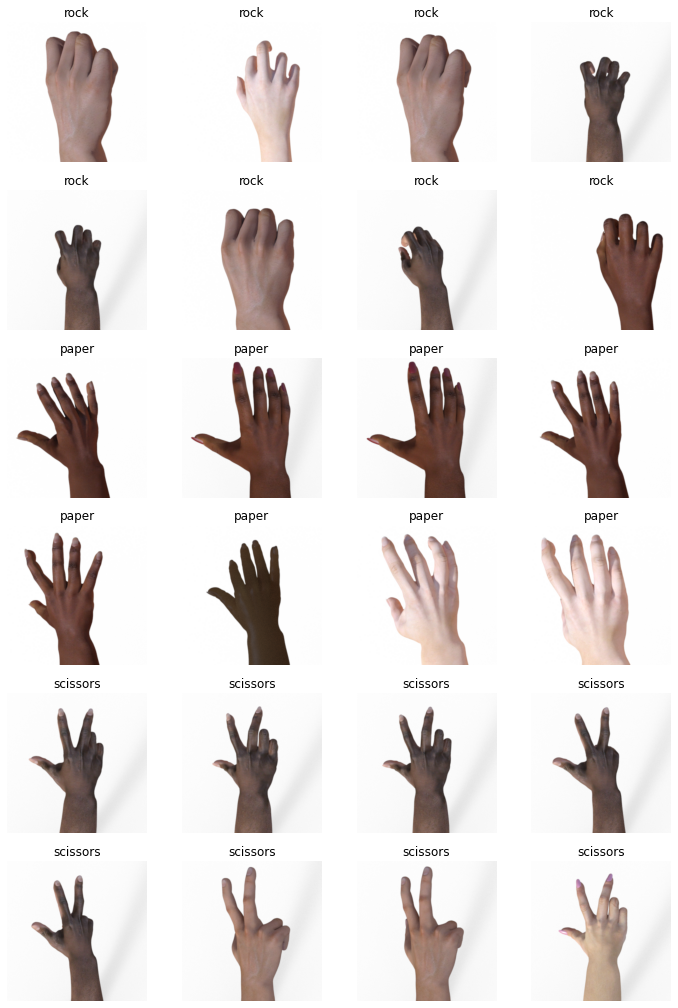

In [21]:
# Number of pictures in the grid
nrows = 6
ncols = 4

# Set up matplotlib fig
longitude_image = 3 # Inches per picture
fig = plt.gcf()
fig.set_size_inches(ncols * longitude_image, nrows * longitude_image)

# Number of pictures to use for each class
pic_index = 8
next_rock_pix = [os.path.join(train_rock_dir, fname) for fname in rock_files[pic_index-8:pic_index]]
next_paper_pix = [os.path.join(train_paper_dir, fname) for fname in paper_files[pic_index-8:pic_index]]
next_scissors_pix = [os.path.join(train_scissors_dir, fname) for fname in scissors_files[pic_index-8:pic_index]]

# Get each image
for i, img_path in enumerate(next_rock_pix+next_paper_pix+next_scissors_pix):
    if os_machine == 'Windows':
        picture_name = img_path.split("\\")[2:4]
    else:
        picture_name = img_path.split("/")[3]
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.title(picture_name)

# Plot grid
plt.show()

## 3. Data Preprocessing

### 3.1. Normalization and Data Augmentation

In [8]:
# Set seed for random functions
tf.random.set_seed(1)

# Define batch size
train_batch = 126
validation_batch = 126

# Data augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,            
    rotation_range=40,         
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generate batches of augmented data for the training set
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),    # Images will be resized to 150x150
    batch_size=train_batch,    # Batch size
    class_mode='categorical'   # When using categorical_crossentropy loss, we need categorical labels
)

# Note that validation data should not be augmented
validation_datagen = ImageDataGenerator(rescale = 1./255.)

# Generate batches of augmented data for the test set
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),        # Images will be resized to 150x150
    batch_size=validation_batch,   # Batch size
    class_mode='categorical'       # When using categorical_crossentropy loss, we need categorical labels
)

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


## 4. Convolutional NN
The **output shape** column in the summary shows how the size of your feature map evolves in each successive layer. The convolution layers reduce the size of the feature maps by a bit due to padding, and each pooling layer halves the dimensions.

In [9]:
# Set seed for random functions
tf.random.set_seed(1)

# Build model
model = tf.keras.models.Sequential([
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile model
model.compile(
    optimizer=RMSprop(lr=1e-4), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

# Print summary
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

## 5. Train

In [10]:
# Get length of each dataset
train_length = len(train_generator.filepaths)
validation_length = len(validation_generator.filepaths)

In [11]:
# Fit the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_length//train_batch, 
    epochs=25,
    verbose=1,
    validation_data=validation_generator,
    validation_steps=validation_length//validation_batch
)

Epoch 1/25
20/20 [==============================] - 44s 2s/step - loss: 1.1104 - accuracy: 0.3341 - val_loss: 1.0661 - val_accuracy: 0.5317
Epoch 2/25
20/20 [==============================] - 43s 2s/step - loss: 1.0683 - accuracy: 0.4197 - val_loss: 0.9619 - val_accuracy: 0.6468
Epoch 3/25
20/20 [==============================] - 43s 2s/step - loss: 1.0068 - accuracy: 0.4802 - val_loss: 0.8805 - val_accuracy: 0.6746
Epoch 4/25
20/20 [==============================] - 44s 2s/step - loss: 0.9236 - accuracy: 0.5637 - val_loss: 0.7710 - val_accuracy: 0.7579
Epoch 5/25
20/20 [==============================] - 44s 2s/step - loss: 0.8621 - accuracy: 0.6191 - val_loss: 0.6988 - val_accuracy: 0.7579
Epoch 6/25
20/20 [==============================] - 44s 2s/step - loss: 0.8040 - accuracy: 0.6604 - val_loss: 0.5987 - val_accuracy: 0.7659
Epoch 7/25
20/20 [==============================] - 43s 2s/step - loss: 0.7242 - accuracy: 0.6793 - val_loss: 0.5022 - val_accuracy: 0.7540
Epoch 8/25
20/20 [==

## 6. Evaluating Accuracy and Loss for the Model

Text(0.5, 0, 'Epochs')

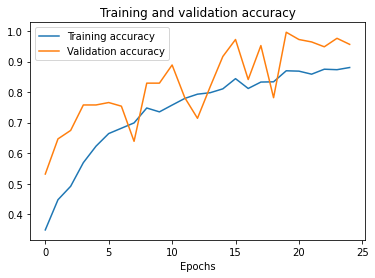

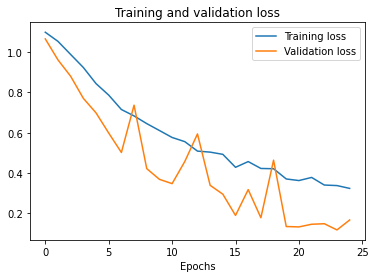

In [12]:
# Get metrics on training and test data
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc)) 

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.legend(loc=0)
plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.legend(loc=0)
plt.title('Training and validation loss')
plt.xlabel('Epochs')

## 7. Use case

In [13]:
# Directory with images to test
use_case_path = './Data/Use_cases/rock-or-paper-or-scissors'

# Get names of pictures
use_case_names = os.listdir(use_case_path)

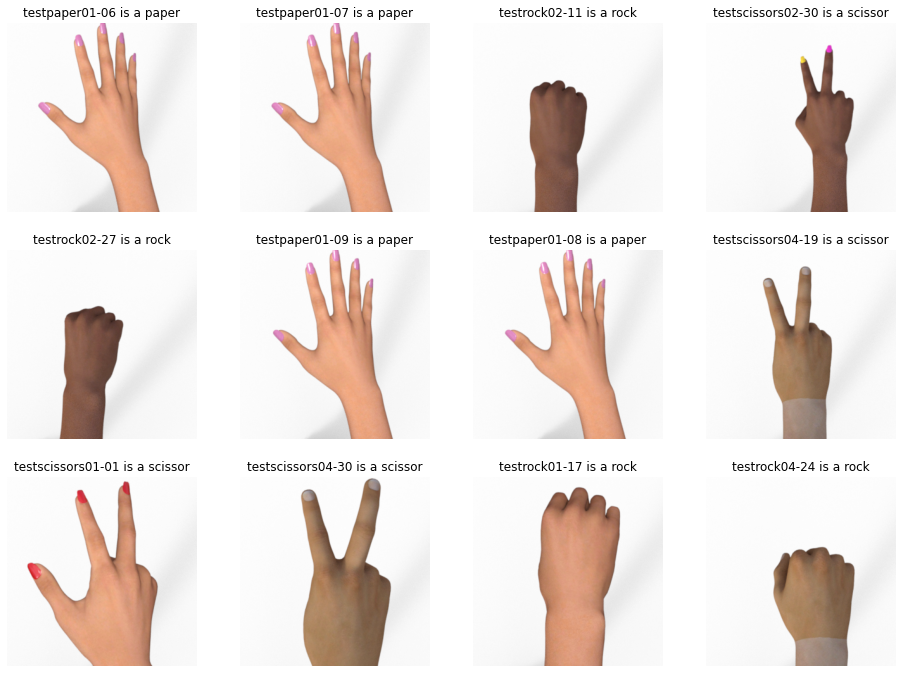

In [19]:
# Number of pictures in the grid
nrows = 4
ncols = 4

# Set up matplotlib fig
longitude_image = 4 # Inches per picture
fig = plt.gcf()
fig.set_size_inches(ncols * longitude_image, nrows * longitude_image)

# Get path to each image
next_use_case_pix = [os.path.join(use_case_path, fname) for fname in use_case_names[:nrows*ncols]]

# Get each image
for i, img_path in enumerate(next_use_case_pix):
    # Prep-process image
    img = load_img(img_path, target_size=(150, 150))  
    x = img_to_array(img)          # Numpy array with shape (150, 150, 3)
    x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)
    x = x/255.0                    # Normalize
    # Predict
    classes = model.predict(x, batch_size=train_batch)
    if os_machine == 'Windows':
        picture_name = img_path.split("\\")[-1]
    else:
        picture_name = img_path.split("/")[-1].split(".")[0]
    if np.argmax(classes[0]) == 0:
        prediction = picture_name + " is a paper"
    elif np.argmax(classes[0]) == 1:
        prediction = picture_name + " is a rock"
    else:
        prediction = picture_name + " is a scissor"
    # Plot image
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.title(prediction)

# Plot grid
plt.show()

## 8. Visualization of convolution

To understand what kind of *features* the convnet is learning, we can visualize how an input gets transformed as it goes through the neural network.

It goes from the raw pixels of the images to increasingly *abstract* and *compact* representations. These representations downstream start highlighting what the network pays attention to, and they show fewer and fewer features being activated; most are set to zero. This is called "*sparsity*." Representation sparsity is a key feature of deep learning.

These representations carry increasingly **less information about the original pixels** of the image, but increasingly **refined information about the class of the image**.

<ipython-input-15-df05613f3998>:43: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std()


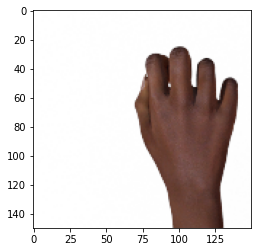

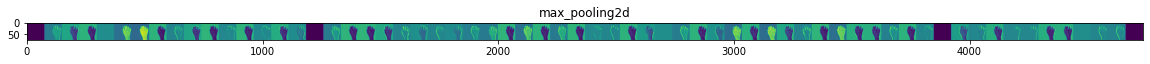

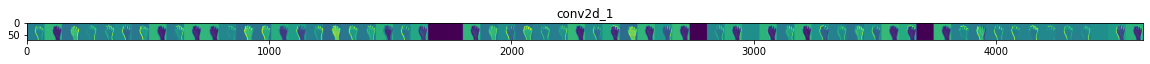

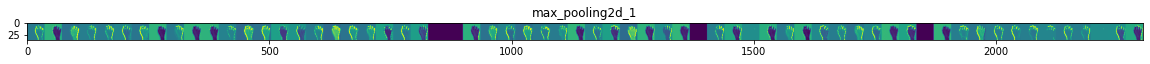

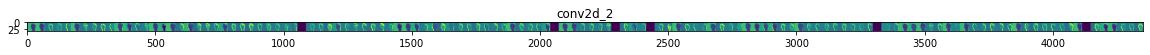

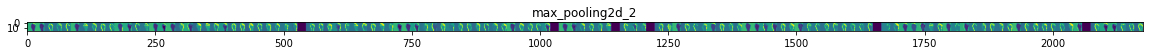

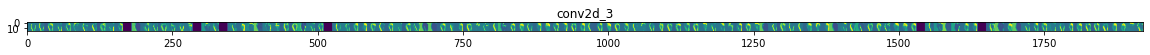

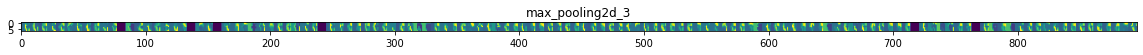

In [15]:
# Take an image and output intermediate representations for all layers 

# Take the layers
successive_outputs = [layer.output for layer in model.layers[1:]]

# Group layers into a model
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Get a random image from the training set
next_rock = [os.path.join(train_rock_dir, fname) for fname in rock_files[pic_index-2:pic_index]]
next_paper = [os.path.join(train_paper_dir, fname) for fname in paper_files[pic_index-2:pic_index]]
next_scissors = [os.path.join(train_scissors_dir, fname) for fname in scissors_files[pic_index-2:pic_index]]
img_path = random.choice(next_rock + next_paper + next_scissors)

# Pre-process the image
img = load_img(img_path, target_size=(150, 150))  
plt.imshow(img)
x = img_to_array(img)          # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Normalize
x = x/255.0

# Run the image through the network to obtain all intermediate representations 
successive_feature_maps = visualization_model.predict(x)

# Get layer's name
layer_names = [layer.name for layer in model.layers[1:]]

# Plot the representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    if len(feature_map.shape) == 4:
        # Number of features in feature map
        n_features = feature_map.shape[-1]  
        # Get the feature map shape (1, size, size, n_features)
        size = feature_map.shape[1]
        # Tile the images in this matrix
        display_grid = np.zeros((size, size * n_features))
        for i in range(n_features):
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            display_grid[:, i * size : (i + 1) * size] = x
        # Display the grid
        scale = 20. / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [16]:
# Print time when finished
now = datetime.now()
print("Finished! At", now.strftime("%Y-%m-%d %H:%M:%S"))

Finished! At 2021-04-24 14:46:45
